[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aalhossary/pyemgpipeline/blob/master/docs/notebooks/ex1_EMGMeasurement.ipynb)

# Example 1 - Single EMG measurement definition and processing (using lower limb data)

This example shows the usage of class
[EMGMeasurement](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.wrappers.html#emgmeasurement)
to process EMG data of one trial.

The data used in this example contains one file of subject #3 in ["EMG dataset in Lower Limb"](https://archive-beta.ics.uci.edu/ml/datasets/emg+dataset+in+lower+limb) from the UC Irvine Machine Learning Repository.
In particular, the data used here was collected from four lower limb muscles (rectus femoris, biceps femoris, vastus internus, and semitendinosus) when the subject was in a sitting posture.

## Package preparation

We install and import needed packages.

In [1]:
!pip install pyemgpipeline -q

In [2]:
import os
import numpy as np
from matplotlib.figure import SubplotParams
import pyemgpipeline as pep

## Data preparation

First download the raw data from the UC Irvine Machine Learning Repository.

When finished, the compressed file "SEMG_DB1.rar" (~14MB) is saved in the "uci_lower_limb" subfolder.

In [3]:
!rm -rf uci_lower_limb
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00278/SEMG_DB1.rar -P ./uci_lower_limb

Uncompress the downloaded file. This example will only use the file "A_TXT/3Asen.txt".

In [4]:
# !unrar x -inul uci_lower_limb/SEMG_DB1.rar uci_lower_limb  #This command extracts all files.
!unrar x -inul uci_lower_limb/SEMG_DB1.rar A_TXT/3Asen.txt uci_lower_limb  #This command extracts only the file needed in this example.

Signal data of each trial should be stored in a 2d ndarray with shape (*n_samples*, *n_channels*), where each column represents data of one channel.

First we set up basic information of the data, including data path, channel names, sample rate, etc.

In [5]:
data_folder = 'uci_lower_limb/A_TXT'
data_filename = '3Asen.txt'
trial_name = 'Sit'
channel_names = ['rectus femoris', 'biceps femoris', 'vastus internus', 'semitendinosus']
sample_rate = 1000

The EMG signal data is then extracted from the raw data file of non-standard format and stored in the 2d ndarray *data*.

In [6]:
def load_uci_lower_limb_txt(_filepath):
    with open(_filepath) as fp:
        collect_values = np.array([])
        lines = fp.readlines()
        for line in lines[7:]:  # first few lines are data description
            items = [float(e) for e in line.split('\t')[:4] if e != '']  # last column is not EMG data
            if len(items) != 4:  # last few rows might not have EMG data
                continue
            collect_values = np.concatenate((collect_values, np.array(items)))
    _data = collect_values.reshape(-1, 4)
    return _data

filepath = os.path.join(data_folder, data_filename)
data = load_uci_lower_limb_txt(filepath)
data

array([[-0.0008, -0.0008,  0.    , -0.0008],
       [-0.0015, -0.0015,  0.0007, -0.003 ],
       [-0.0008, -0.0008, -0.0008, -0.0015],
       ...,
       [-0.0008, -0.0015,  0.    ,  0.0015],
       [ 0.0007, -0.0008,  0.    , -0.0008],
       [ 0.    ,  0.0007, -0.0008,  0.    ]])

In [7]:
print('data shape:', data.shape)

data shape: (38971, 4)


We also set up the parameters for plotting with an instance of class
[EMGPlotParams](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.plots.html#emgplotparams).

In [8]:
emg_plot_params = pep.plots.EMGPlotParams(
    n_rows=4,
    fig_kwargs={
        'figsize': (8, 6),
        'dpi': 80,
        'subplotpars': SubplotParams(wspace=0, hspace=0.6),
    },
    line2d_kwargs={
        'color': 'red',
    }
)

## Data processing

We initialize an instance of class
[EMGMeasurement](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.wrappers.html#emgmeasurement)
with signal data *data* and other information, which is responsible for furtuer processing and plotting.

In [9]:
m = pep.wrappers.EMGMeasurement(data, hz=sample_rate, trial_name=trial_name,
                                channel_names=channel_names, emg_plot_params=emg_plot_params)

We also visualize the data before processing:

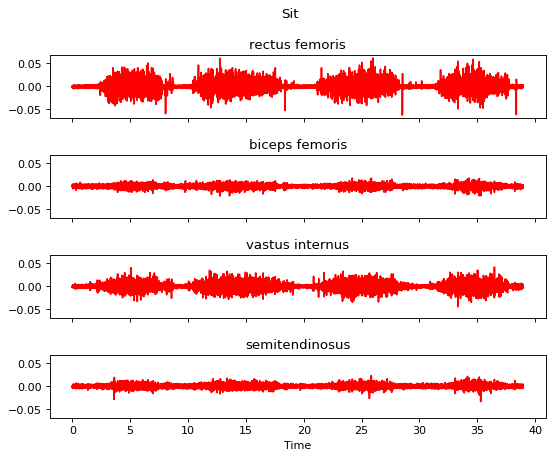

In [10]:
m.plot()

Now we start to apply seven processing steps one by one and visualize the data after each step.

Step 1 is the DC offset removal.

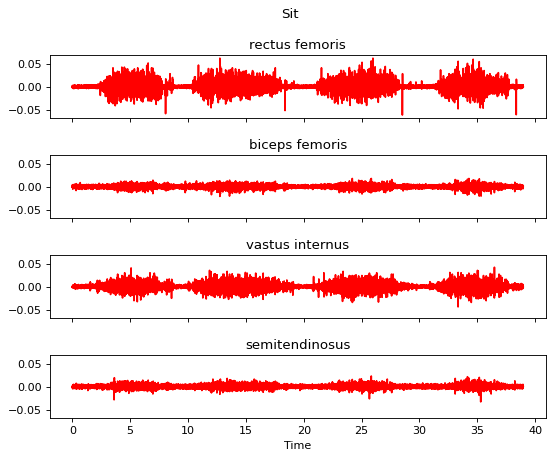

In [11]:
m.apply_dc_offset_remover()
m.plot()

Step 2 is the bandpass filtering.

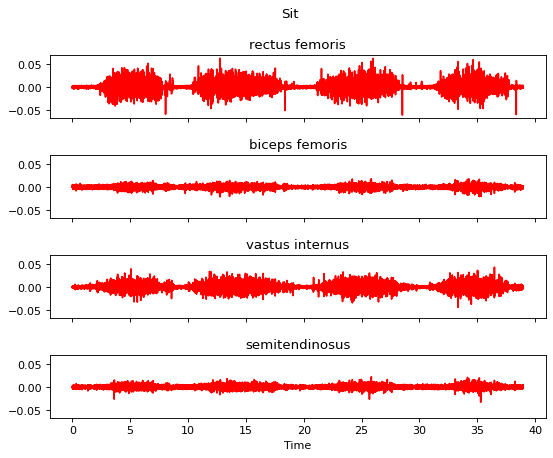

In [12]:
m.apply_bandpass_filter(bf_order=4, bf_cutoff_fq_lo=10, bf_cutoff_fq_hi=450)
m.plot()

Step 3 is the full wave rectification.

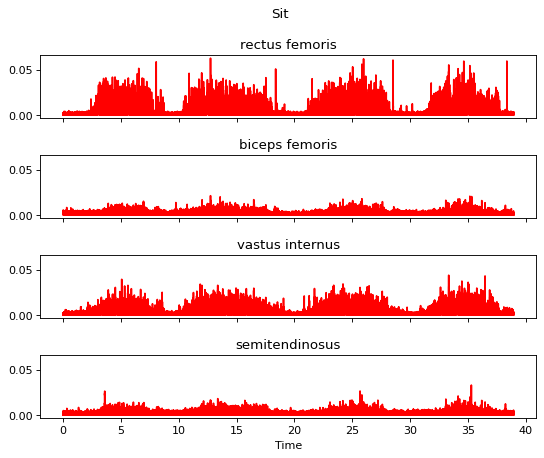

In [13]:
m.apply_full_wave_rectifier()
m.plot()

Step 4 is the linear envelope.

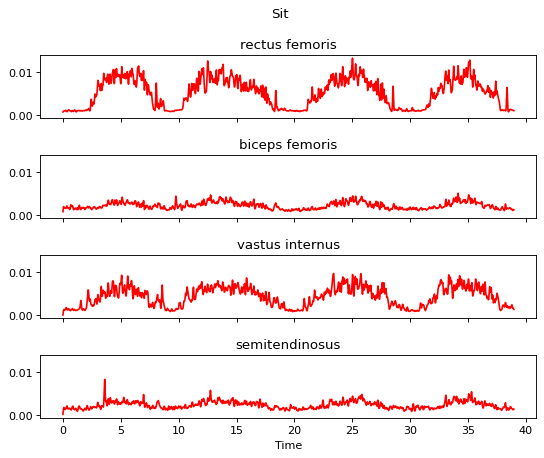

In [14]:
m.apply_linear_envelope(le_order=4, le_cutoff_fq=6)
m.plot()

Step 5 is the end frame cutting.

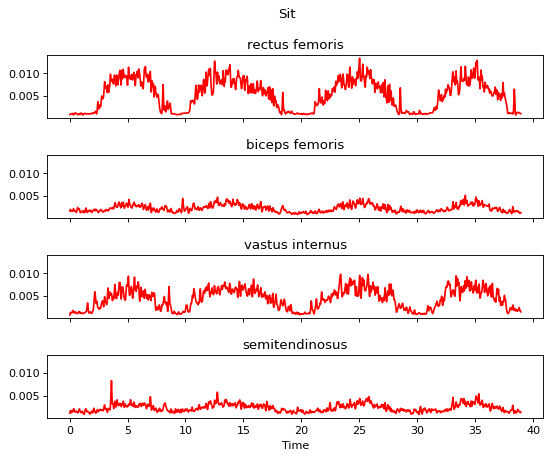

In [15]:
m.apply_end_frame_cutter(n_end_frames=30)
m.plot()

Step 6 is the amplitude normalization.
Here we assume the MVC (maximum voluntary contraction) of each muscle of this subject is already obtained from the whole experiments.

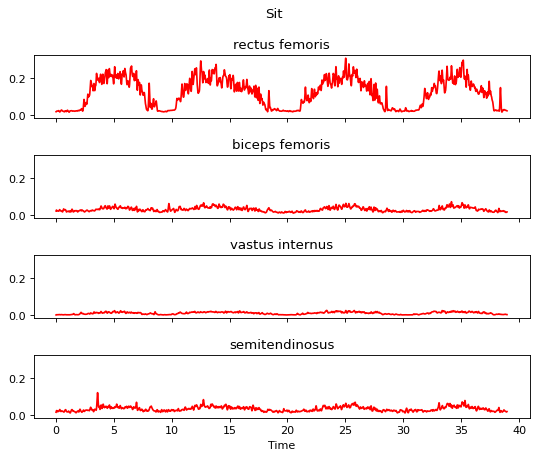

In [16]:
max_amplitude = [0.043, 0.069, 0.364, 0.068]  # assume the MVC is known
m.apply_amplitude_normalizer(max_amplitude)
m.plot()

Step 7 is the segmentation.
For demonstration purpose, assume the segment of interest is in the time range (20.5, 29.5).

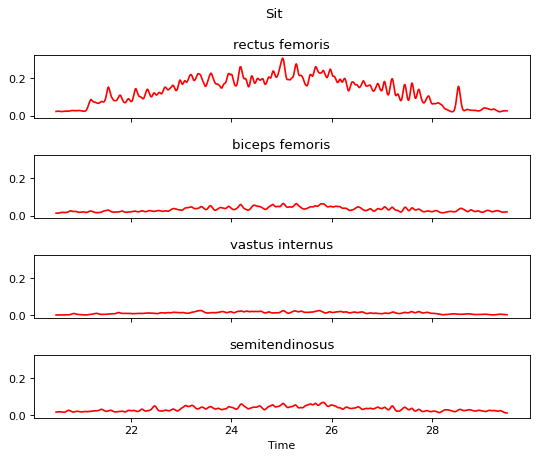

In [17]:
m.apply_segmenter(20.5, 29.5)
m.plot()

We have completed the processing steps.
The processed signal data can be accessed via *m.data* while the timestamp (initially derived from *sample_rate*) can be accessed via *m.timestamp* whenever needed.

In [18]:
m.data

array([[0.02186312, 0.01239804, 0.00273551, 0.01773494],
       [0.02193963, 0.0123964 , 0.00273592, 0.01775758],
       [0.02201485, 0.0123954 , 0.00273646, 0.01778186],
       ...,
       [0.02519068, 0.01955036, 0.00408111, 0.01343851],
       [0.02520053, 0.01955799, 0.00405828, 0.01344915],
       [0.02521111, 0.01956411, 0.00403501, 0.01346193]])

In [19]:
m.timestamp

array([20.5  , 20.501, 20.502, ..., 29.498, 29.499, 29.5  ])

The processed data can also be exported to a csv file. Note that besides signal data, timestamp is also included in the first column of the csv file.

In [20]:
m.export_csv('ex1_processed.csv')